In [150]:
import matplotlib, sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("./mylib/")
sys.path.append("../../Env/")

import numpy as np
import matplotlib.pyplot as plt

np.seterr(all="ignore")
from threeML import *
from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import traceback
silence_warnings()
import warnings
warnings.simplefilter("ignore")
silence_warnings()
from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
from threeML.utils.progress_bar import trange

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
from astropy.coordinates import Angle

import healpy as hp

from tqdm import tqdm

# from mylib import *
import mylib as my
from importlib import reload

In [151]:
%matplotlib inline
region_name="GRB221009A"
if not os.path.exists(f'../res/{region_name}/'):
    os.system(f'mkdir ../res/{region_name}/')
GRB221009A = my.lc("../../data/lc_data/GRB221009A/GRBlcunbin.root", ebin=11, funcfile="../../data/lc_data/GRB221009A/func.root") #funcfile="../../data/lc_data/GRB221009A/bkg.npy"
GRB221009A_trig = my.lc("../../data/lc_data/GRB221009A/1009_nf_dt.root", tname="h;1", bkgfile="../../data/lc_data/GRB221009A/1008_nf_dt.root", bkgscale=2)

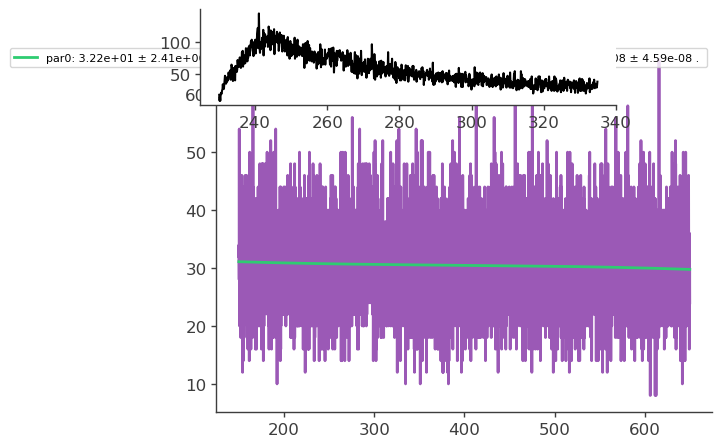

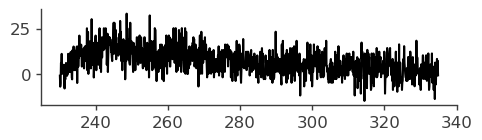

100%|██████████| 7000/7000 [00:00<00:00, 7976.14it/s]


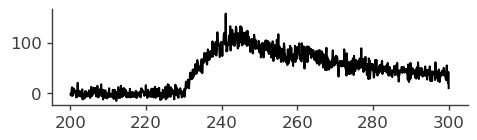

In [152]:
bin_t = 0.1
rebins = int(10000*bin_t)
GRB221009A.rebin(rebins)
GRB221009A_trig.rebin(rebins)
GRB221009A_trig.fitbkg(my.poly , 150, 650, p0=[2, 2, 20, 2], plot=True)
GRB221009A.drawlc(drawbkg=True)
GRB221009A_trig.drawlc()
GRB221009Aall = GRB221009A + GRB221009A_trig
GRB221009Aall.drawlc(200,300)

(226.0, 300.0)

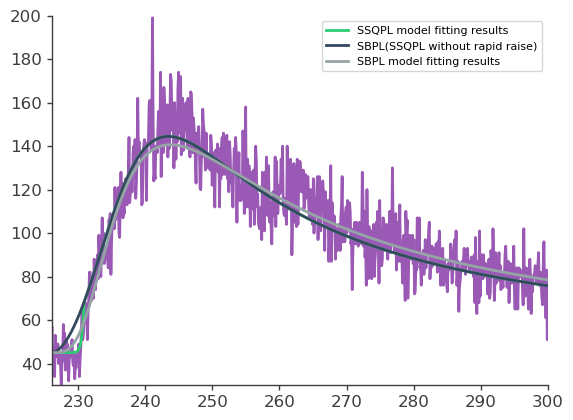

Load sub from Mystat: : 40it [00:13, 162.02it/s]

In [156]:
datas = GRB221009A.getdatafram(subbkg=False)
xx = np.linspace(200, 700, 10000)
                            #  F0,  tb,    o1,   a1,    a2, t0,  o2,   tB,      a3,  tb0,   a0
# plt.plot(xx,fSSQPL(xx-226, [240, 13.72, 0.71, 2.30, -1.14, 0, 4.49, 666.64, -2.59, 4.96, 11.21])+45)
# plt.plot(xx,SBPL(xx-226, [240, 13.72, 0.71, 2.30, -1.14, 0, 4.49, 666.64, -2.59, 4.96, 11.21])+45)
plt.plot(datas["x"], datas["y"])
plt.plot(xx,my.fSSQPL(xx-226, [185, 14.9, 1.07, 1.82, -1.115, 0, 7.4, 670, -2.21, 4.85, 14.9])+45, label="SSQPL model fitting results")
plt.plot(xx,my.fSBPL(xx-226, [185, 14.9, 1.07, 1.82, -1.115, 0, 7.4, 670, -2.21, 4.85, 14.9])+45, label="SBPL(SSQPL without rapid raise)")
plt.plot(xx,my.fSBPL(xx-226, [360, 9.89, 0.41, 3.81, -1.16, 0, 4.8, 678, -2.6])+45, label="SBPL model fitting results")
plt.legend()
plt.ylim(30, 200)
plt.xlim(226,300)

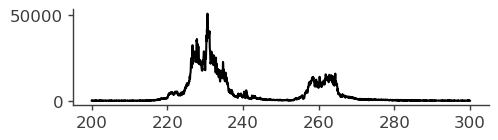

In [7]:
GRB221009A_prompr = my.lc('../../data/lc_data/GRB221009A/hebs-2.txt')
# GRB221009A_prompr.rebin(10)
GRB221009A_prompr.drawlc(200,300)

(100.0, 5000.0)

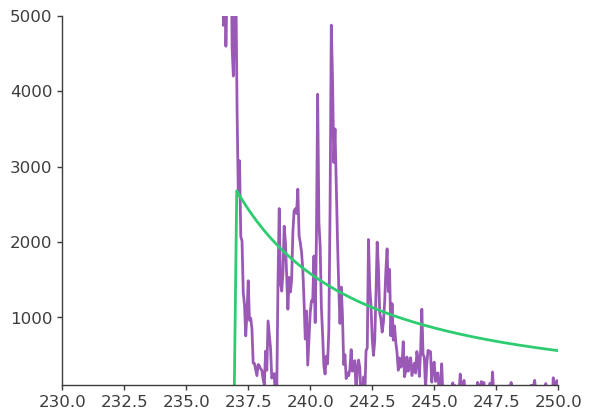

In [10]:
def powerlawlc(t, A, index, t0):
    result = A*(t-t0)**(index)
    result[t<=237]=0
    return result

promptdata = GRB221009A_prompr.getdatafram(subbkg=False)
plt.plot(promptdata["x"], promptdata["y"]-powerlawlc(promptdata["x"], 0.5e5, -1.5, 230)) #
xx = np.linspace(200,300,1000)
plt.plot(xx, powerlawlc(xx, 0.5e5, -1.5, 230))
plt.xlim(230, 250)
plt.ylim(1e2, 5000)
# plt.xscale("log")
# plt.yscale("log")

In [185]:
t0=235
te=250
datafgrb = GRB221009Aall.getdatafram(subbkg=False)
datafgrb = datafgrb[(datafgrb["x"]>=t0) & (datafgrb["x"]<=te)]

14:06:07 INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=644270;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=70038;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/plugins/XYLike.py#89\89]8;;\

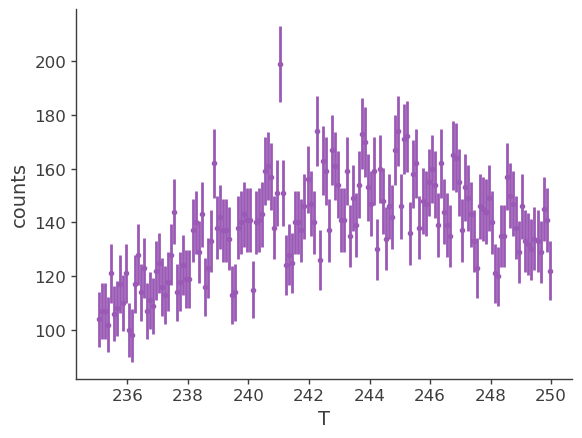

In [186]:
GRBlike = XYLike.from_dataframe("GRB221009A", datafgrb, poisson=False)
fig = GRBlike.plot(x_label="T", y_label="counts")

In [202]:
lcmodel = my.SBPL()
lcmodel.alpha1.bounds = (0,10)
lcmodel.alpha2.bounds = (-10,0)
lcmodel.F0 = 1000
lcmodel.F0.bounds = (0.1,10000)
lcmodel.t0=226
lcmodel.t0.bounds = (220, 235)
lcmodel.t0.fix=True

linebkg = Cubic()
linebkg.a = 113.27776
linebkg.a.fix = True
linebkg.b = -0.03
linebkg.b.fix = True
linebkg.c = 2.6e-06
linebkg.c.fix = True
linebkg.d = -6.18e-11
linebkg.d.fix = True

linebkgtri = Cubic()
linebkgtri.a = 3.22202619e+02
linebkgtri.a.fix = True
linebkgtri.b = -1.06140647e-01
linebkgtri.b.fix = True
linebkgtri.c = 2.37156727e-04
linebkgtri.c.fix = True
linebkgtri.d = -2.03058449e-07
linebkgtri.d.fix = True

lineafterglow = Cubic()
# lineafterglow.a.bounds = (0,1000)
# lineafterglow.b.bounds = (-10,10)
# lineafterglow.c.bounds = (-10,10)


gauss = Gaussian()
gauss.F.bounds = (0,20000)
gauss.mu.bounds = (230,255)
gauss.sigma = 5
# gauss.sigma.min = 0.1
# gauss.sigma.max = 3
gauss.sigma.bounds = (0,8)

gauss2 = Gaussian()
gauss2.F.bounds = (0,20000)
gauss2.mu.bounds = (250,270)
gauss2.sigma = 2
# gauss2.sigma.min = 0.1
# gauss2.sigma.max = 3
gauss2.sigma.bounds = (0,5)

gauss3 = Gaussian()
gauss3.F.bounds = (0,20000)
gauss3.mu.bounds = (227,245)
gauss3.sigma = 2
# gauss3.sigma.min = 0.1
# gauss3.sigma.max = 3
gauss3.sigma.bounds = (0,4)

hebs = my.HEBS()
hebs.A.bounds = (1,2e15)
hebs.ts = 250               #!!!!!!!!!!!!!!!!!!
hebs.ts.fix = True
# hebs.ts.bounds = (226, 235)
hebs.te = 270
hebs.dt.bounds = (-1,3)
hebs.bint=bin_t
hebs.bint.fix = True

hebs2 = my.HEBS()
hebs2.A.bounds = (1,20000)
hebs2.ts = 229               #!!!!!!!!!!!!!!!!!!
hebs2.te = 235
hebs2.dt.bounds = (0,2)
hebs2.bint=bin_t

hebs3 = my.HEBS()
hebs3.A.bounds = (1,20000)
hebs3.ts = 239               #!!!!!!!!!!!!!!!!!!
hebs3.te = 242
hebs3.dt.bounds = (0,2)
hebs3.bint=bin_t

lcmodelf = lcmodel + linebkg*bin_t + linebkgtri*bin_t
lcmodelf2 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss
lcmodelf22 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + gauss3
lcmodelf3 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + gauss2
lcmodelf32 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + gauss2 + gauss3
lcmodelf4 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + hebs
lcmodelf42 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + hebs + gauss3
# lcmodelf5 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + hebs + hebs2
# lcmodelf6 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + hebs + hebs2 + hebs3
linehebs2 = lineafterglow + linebkg*bin_t + linebkgtri*bin_t + hebs
src = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf)
src2 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf2)
src22 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf22)
src3 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf3)
src32 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf32)
src4 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf4)
src42 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf42)
# src5 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf5)
# src6 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf6)

srcline2 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=linehebs2)

model1 = Model(src)
model2 = Model(src2)
model22 = Model(src22)
model3 = Model(src3)
model32 = Model(src32)
model4 = Model(src4)
model42 = Model(src42)

modelline3 = Model(srcline2)
# model5 = Model(src5)
# model6 = Model(src6)
# model1.display(complete=True)
# model2.display(complete=True)
# model22.display(complete=True)
# model3.display(complete=True)
# model32.display(complete=True)
# model4.display(complete=True)
# model42.display(complete=True)
# model5.display(complete=True)
# model6.display(complete=True)

In [203]:
if lcmodel.t0.fix:
    fixtxt=f"fixt0{lcmodel.t0.value}"
else:
    fixtxt=f"freet0"

Modelname=f"lc{bin_t}+cubic+linebkg+hebs_250_270"
if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
    os.system(f'mkdir ../res/{region_name}/{Modelname}/')
modelline3.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
result = my.fit(region_name, Modelname, GRBlike, modelline3, mini="ROOT", grids={modelline3.GRB221009A.spectrum.main.composite.dt_4: np.linspace(-0.9, 2.9, 10)}, donwtlimit=False)
#, model4.GRB221009A.spectrum.main.composite.ts_5: np.linspace(230, 234, 2)


# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model1.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model1, mini="ROOT", donwtlimit=False)

# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg+gauss"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model2.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model2, mini="ROOT", grids={model2.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 10), model2.GRB221009A.spectrum.main.composite.sigma_4: np.linspace(2, 6, 10)}, donwtlimit=False)

# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg+gauss3+gauss"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model22.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model22, mini="ROOT", grids={model22.GRB221009A.spectrum.main.composite.mu_5: np.linspace(230, 244, 10), model22.GRB221009A.spectrum.main.composite.sigma_5: np.linspace(0.5, 3, 10)}, donwtlimit=False)

# Modelname="lc1+SBPLfreet0+linebkg+2*gauss"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model3.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model3, mini="ROOT", grids={model3.GRB221009A.spectrum.main.composite.mu_5: np.linspace(256, 269, 10), model3.GRB221009A.spectrum.main.composite.sigma_5: np.linspace(0.5, 4, 10)}, donwtlimit=False)

# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg+gauss3+2gauss"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model32.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model32, mini="ROOT", grids={model32.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 10), model32.GRB221009A.spectrum.main.composite.sigma_4: np.linspace(1, 7, 10)}, donwtlimit=False)

# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg+gauss+hebs_229_270"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model4.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model4, mini="ROOT", grids={model4.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 2), model4.GRB221009A.spectrum.main.composite.dt_5: np.linspace(0.1, 1.9, 2)}, donwtlimit=False)
# #, model4.GRB221009A.spectrum.main.composite.ts_5: np.linspace(230, 234, 2)

# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg+gauss+hebs_250_270+gauss3"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model42.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model42, mini="ROOT", grids={model42.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 2), model42.GRB221009A.spectrum.main.composite.dt_5: np.linspace(0.1, 1.9, 2)}, donwtlimit=False)

# Modelname="lc0.1+SBPL+linebkg+gauss+hebs_250_270+hebs_239_242"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model5.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model5, mini="ROOT", grids={model5.GRB221009A.spectrum.main.composite.mu_3: np.linspace(230, 290, 5)}, donwtlimit=False) #, model5.GRB221009A.spectrum.main.composite.dt_4: np.linspace(-2, 2, 5)

# Modelname="lc0.1+SBPL+linebkg+gauss+hebs_250_270+hebs_229_235"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model5.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model5, mini="ROOT", grids={model5.GRB221009A.spectrum.main.composite.mu_3: np.linspace(230, 290, 5)}, donwtlimit=False) # model5.GRB221009A.spectrum.main.composite.dt_4: np.linspace(-2, 2, 5), model5.GRB221009A.spectrum.main.composite.dt_5: np.linspace(-2, 2, 5)


# Modelname="lc0.1+SBPL+linebkg+gauss+hebs_250_270+hebs_229_235+hebs_239_242"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model6.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model6, mini="ROOT", donwtlimit=False) # model5.GRB221009A.spectrum.main.composite.dt_4: np.linspace(-2, 2, 5), model5.GRB221009A.spectrum.main.composite.dt_5: np.linspace(-2, 2, 5) , grids={model6.GRB221009A.spectrum.main.composite.mu_3: np.linspace(228, 254, 1)}

20:50:24 INFO      set the minimizer to minuit                                             ]8;id=724731;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=673606;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to grid                                               ]8;id=716451;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=148127;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

Grid Minimization:   0%|          | 0/10 [00:00<?, ?it/s]

20:51:50 INFO                                                                               ]8;id=613423;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=59698;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#294\294]8;;\
                                                                                                                   
                  Results after global minimizer (before secondary optimization):                                  

,result,unit
parameter,,
GRB221009A.spectrum.main.composite.a_1,(4.955791580374873 +/- 0) x 10,1 / (keV s cm2)
GRB221009A.spectrum.main.composite.b_1,(-1.7235634496158443 +/- 0) x 10^3,1 / (s cm2 keV2)
GRB221009A.spectrum.main.composite.c_1,(1.421502248431088 +/- 0) x 10,1 / (s cm2 keV3)
GRB221009A.spectrum.main.composite.d_1,(-2.929628232848274 +/- 0) x 10^-2,1 / (s cm2 keV4)
GRB221009A.spectrum.main.composite.A_4,(8.143072562167786 +/- 0) x 10^13,
GRB221009A.spectrum.main.composite.dt_4,2.919181879641939 +/- 0,s


         INFO                                                                               ]8;id=516109;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=392581;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#300\300]8;;\
                  Total log-likelihood minimum: 6915.313                                                           
                                                                                                                   

CannotComputeCovariance: HESSE failed. Reason: Covariance matrix is not positive defined (status: 300)

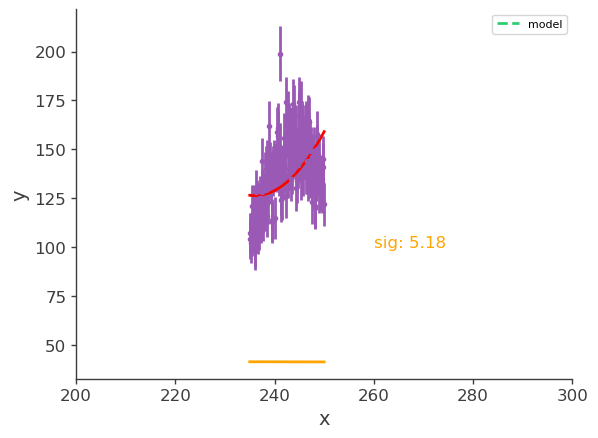

In [200]:
%matplotlib inline
GRBlike.plot()

xx = np.arange(t0,te,0.001)

# yy = lcmodelf(xx)
# plt.plot(xx,yy, color="red")

yy = linehebs3(xx)
plt.plot(xx,yy, color="red")

# yy0 = (linebkg*bin_t+linebkgtri*bin_t+gauss3)(xx)
# plt.plot(xx,yy0, color="blue")

# yy2 = (linebkg*bin_t+linebkgtri*bin_t+gauss)(xx)
# plt.plot(xx,yy2, color="black")
# yy3 = (linebkg*bin_t+linebkgtri*bin_t+gauss2)(xx)
# plt.plot(xx,yy3, color="green")

yy4 = (linebkg*bin_t+linebkgtri*bin_t+hebs)(xx)
plt.plot(xx,yy4, color="orange")

# yy5 = (linebkg*bin_t+hebs2)(xx)
# plt.plot(xx,yy5, color="orange")

# yy6 = (linebkg*bin_t+hebs3)(xx)
# plt.plot(xx,yy6, color="orange")

plt.xlim(200,300)
plt.annotate(f"sig: {my.calculate_significance(2, 4811.10, 4795.08):.2f}", (260, 100), color="orange")

plt.savefig(f"../res/{region_name}/{Modelname}/lc.png", dpi=300)
plt.savefig(f"../res/{region_name}/{Modelname}/lc.pdf", dpi=300)

plt.show()

In [43]:
my.calculate_significance(2, 284.780755, 269.037812)

5.129156893015179